### Jax experiments
I installed jax with cuda support with:
```bash
pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
```

In [1]:
# test the jax installation
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


### Homography with skimage
I installed skimage (`pip install scikit-image`) to use its homography function as a baseline 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage import transform


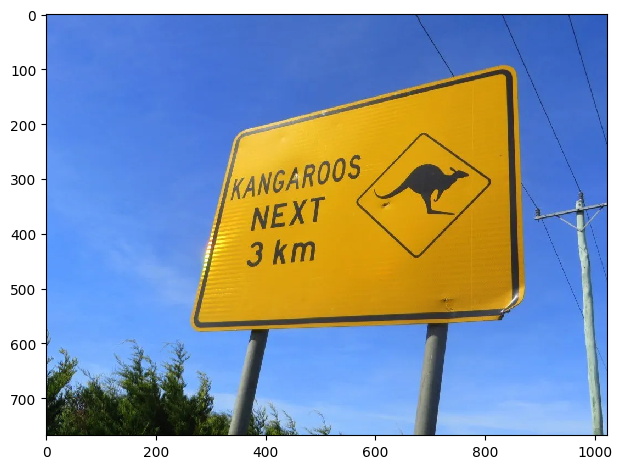

In [3]:
# loading a test image
sign = imread('images/Kangaroo-road-sign.png')
imshow(sign)


In [4]:
# those are the coordinates of the angles of the sign in the image, the ones
# that have to be projected
area_of_interest = [(350, 210),
                    (850, 75),
                    (860, 560),
                    (260, 570)]

# this is the area of projection (it will be a front face rectangle)
area_of_projection = [(100, 100),
                      (900, 100),
                      (900, 600),
                      (100, 600)]


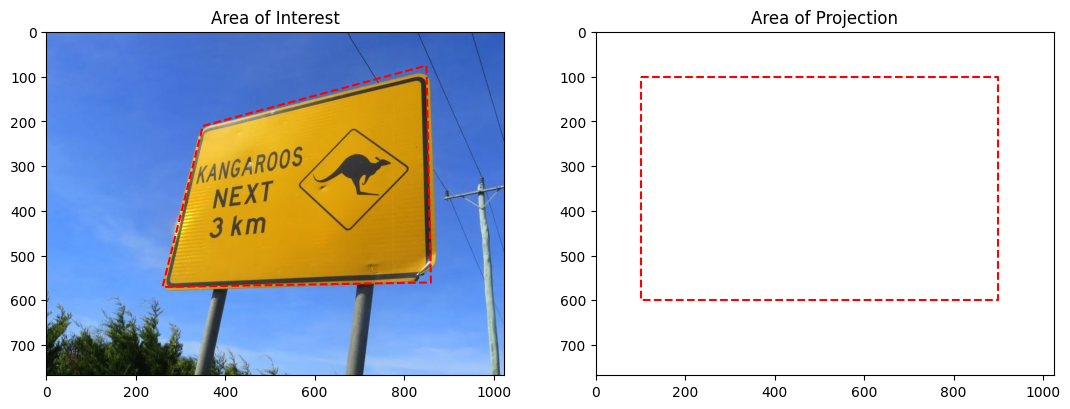

In [5]:
# visualization of the area of interest and area of projection to be used
def project_planes(image, src, dst):
    x_src = [val[0] for val in src] + [src[0][0]]
    y_src = [val[1] for val in src] + [src[0][1]]
    x_dst = [val[0] for val in dst] + [dst[0][0]]
    y_dst = [val[1] for val in dst] + [dst[0][1]]

    fig, ax = plt.subplots(1, 2, figsize=(13, 6))

    new_image = image.copy()
    projection = np.zeros_like(new_image)
    ax[0].imshow(new_image);
    ax[0].plot(x_src, y_src, 'r--')
    ax[0].set_title('Area of Interest')
    ax[1].imshow(projection)
    ax[1].plot(x_dst, y_dst, 'r--')
    ax[1].set_title('Area of Projection')


project_planes(sign, area_of_interest, area_of_projection)

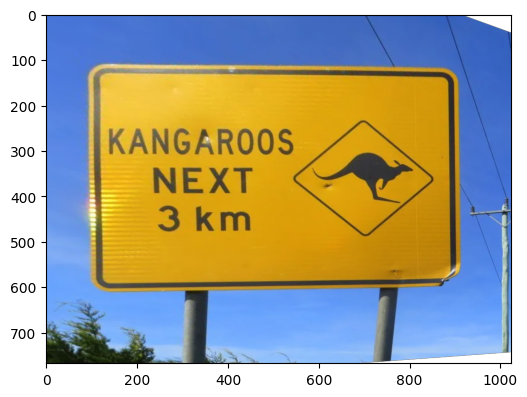

In [6]:
# calculate homography matrix and then apply the transformation
def project_transform(image, src, dst):
    tform = transform.estimate_transform('projective',
                                         np.array(dst),
                                         np.array(src))
    return transform.warp(image, tform)


proj = project_transform(sign, area_of_interest, area_of_projection)

plt.figure(figsize=(6, 6))
plt.imshow(proj)


### skimage perfomances

In [7]:
def calculate_matrix(src, dst):
    tform = transform.estimate_transform('projective',
                                         np.array(dst),
                                         np.array(src))
    return tform

In [8]:
sci_hom = calculate_matrix(area_of_interest, area_of_projection)
%timeit sci_hom = calculate_matrix(area_of_interest, area_of_projection)

239 μs ± 9.01 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
# from skimage import transform
%timeit transform.warp(sign, sci_hom)

79.6 ms ± 138 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### JAX implementation 
Here I implement in JAX the estimate function for homography and then the warp function to project the image  

In [10]:
import jax
import jax.numpy as jnp

In [13]:
# jax.config.update("jax_enable_x64", True)
@jax.jit
def homography(src, dst):
    @jax.vmap
    def build_matrix(p, q):
        x, y = p
        u, v = q
        return jnp.array([
            [x, y, 1, 0, 0, 0, -x*u, -y*u],
            [0, 0, 0, x, y, 1, -x*v, -y*v]
        ])

    P = build_matrix(src, dst).reshape(-1, 8)
    b = dst.ravel()

    h, _, _, _ = jnp.linalg.lstsq(P, b, rcond=0)
    # x = jnp.linalg.solve(A, b)

    return jnp.pad(h, (0, 1), constant_values=1.0).reshape(3, 3)
    


In [14]:
# a test run, to compare two homography matrix, the jax and skimage one
x1s = jnp.array([[350, 210], [850, 75], [860, 560], [260, 570]])
x2s = jnp.array([[100, 100], [900, 100], [900, 600], [100, 600]])
hom = homography(x2s, x1s)
hom, sci_hom

(Array([[ 3.1381023e-01, -2.2250760e-01,  3.1007532e+02],
        [-1.9802594e-01,  4.9209756e-01,  1.7951300e+02],
        [-3.3408584e-04, -2.7887538e-04,  1.0000000e+00]], dtype=float32),
 <ProjectiveTransform(matrix=
     [[ 3.26358652e-01, -2.48243832e-01,  3.20796807e+02],
      [-1.81416304e-01,  5.02264151e-01,  1.65080189e+02],
      [-3.06402193e-04, -3.04789550e-04,  1.00000000e+00]]) at 0x7a7cc7556480>)

In [15]:
# some performance test, doing worse than skimage in estimating the homography
with jax.default_device(jax.devices('cpu')[0]):
    %timeit homography(x2s, x1s).block_until_ready()


379 μs ± 27.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Hereafter I implement the warp function 


In [16]:
import jax
import jax.numpy as jnp

@jax.jit
def jax_warp_image(image, H):
    h, w, c = image.shape

    y, x, z = jnp.mgrid[:h, :w, :c]
    
    x_flat = x[:, :, 0]
    y_flat = y[:, :, 0]
    z_flat = jnp.ones_like(x_flat)  # we are working in homogeneous coordinates, we need the ones on the z
    
    # apply homography
    projected = jnp.einsum('ij,j...->...i', H, jnp.stack([x_flat, y_flat, z_flat]))
    
    # normalize
    x_norm = projected[:, :, 0] / projected[:, :, 2]
    y_norm = projected[:, :, 1] / projected[:, :, 2]
    
    # expand the x's and the y's (as the same shape of the image, otherwise interpolation doesnt work)
    x_exp = jnp.tile(x_norm[:, :, jnp.newaxis], (1, 1, c))
    y_exp = jnp.tile(y_norm[:, :, jnp.newaxis], (1, 1, c))
        
    return jax.scipy.ndimage.map_coordinates(sign, [y_exp, x_exp, z], order=1, mode='nearest')
    


### Alternate version, with jnp.dot
I asked chatgpt for an alternative to my function and it came up with a version where it doesnt expand the color channel planes and it uses jnp.dot. 
*NOTE It is important to note that only after I came up with a working warp function I could get variants more or less working*


In [17]:

import jax
import jax.numpy as jnp
from jax.scipy.ndimage import map_coordinates

@jax.jit
def jax_warp_image_alt(image, H):
    h, w, c = image.shape

    # create mesh grid of (x, y) coordinates, not for the channels
    # so it saves memory
    y, x = jnp.mgrid[:h, :w]

    # flatten and convert to homogeneous coordinates
    coords = jnp.stack([x.ravel(), y.ravel(), jnp.ones_like(x).ravel()])

    # apply homography, classical matrix mul
    projected = jnp.dot(H, coords)
    
    # normalize coordinates (convert from homogeneous)
    x_norm = projected[0] / projected[2]
    y_norm = projected[1] / projected[2]

    # reshape back to image grid
    x_norm = x_norm.reshape(h, w)
    y_norm = y_norm.reshape(h, w)

    # expand coordinates for interpolation
    x_exp = x_norm[..., jnp.newaxis]
    y_exp = y_norm[..., jnp.newaxis]

    # perform interpolation one channel at the time and then stack all 
    # the interpolated planes together
    warped_image = jnp.stack([
        map_coordinates(image[..., i], [y_exp[..., 0], x_exp[..., 0]], order=1, mode='nearest')
        for i in range(c)
    ], axis=-1)

    return warped_image


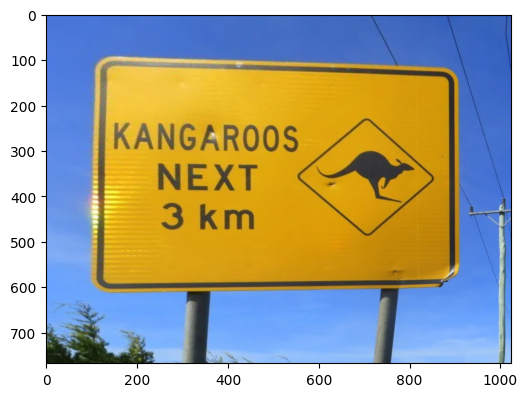

In [18]:
warped_image = jax_warp_image_alt(sign, hom)
plt.figure(figsize=(6, 6))
plt.imshow(warped_image)

### JAX performances

In [19]:
# homography implemented in jax, with jit, on cpu
with jax.default_device(jax.devices('cpu')[0]):
    %timeit jax_warp_image(sign, hom).block_until_ready()

11.2 ms ± 106 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
# alternate version of warp transform it is slower on cpu
with jax.default_device(jax.devices('cpu')[0]):
    %timeit jax_warp_image_alt(sign, hom).block_until_ready()

14.7 ms ± 41.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
# homography implemented in jax, with jit, on gpu (1080Ti, I am poor)
with jax.default_device(jax.devices('gpu')[0]):
    gpu_sign = jax.device_put(sign, jax.devices('gpu')[0])
    gpu_hom = jax.device_put(hom, jax.devices('gpu')[0])
    %timeit jax_warp_image(gpu_sign, gpu_hom).block_until_ready()

1.23 ms ± 11.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [24]:
# alternative warp transform with jnp.dot on gpu, the fastest!
with jax.default_device(jax.devices('gpu')[0]):
    gpu_sign = jax.device_put(sign, jax.devices('gpu')[0])
    gpu_hom = jax.device_put(hom, jax.devices('gpu')[0])
    %timeit jax_warp_image_alt(gpu_sign, gpu_hom).block_until_ready()

883 μs ± 51.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
